In [2]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import rasterio
from cartopy.io.img_tiles import OSM, GoogleTiles
from matplotlib.patches import Circle

In [3]:
meta = pd.read_csv("../../metadata/supp1.csv")

In [9]:
#overview of karyotypes: 
for inv in ['2Rt', '2Ra', '2Rh', '3Ra', '3Rb', '3La']:
    print(meta[f'karyotype_{inv}'].unique())

['2R+/+' '2R+/t']
['2Ra/a' '2R+/a' '2R+/+']
['2R+/+' '2R+/h' '2Rh/h']
['3R+/a' '3Ra/a' '3R+/+']
['3Rb/b' '3R+/b' '3R+/+']
['untyped' '3La/a' '3L+/a' '3L+/+']


In [6]:
#Add code
codedict = dict({
    'Ghana_Northern-Region': 'GH-N', 
    'Gabon_Haut-Ogooue': 'GA', 
    'CAR_Ombella-MPoko': 'CF',
    'Cameroon_Adamawa': 'CM', 
    'Ghana_Ashanti-Region': 'GH-A',
    'Malawi_Southern-Region': 'MW', 
    'Mozambique_Maputo': 'MZ-M',
    'Uganda_Eastern-Region': 'UG', 
    'Benin_Atlantique-Dept': 'BJ', 
    'DRC_Kinshasa': 'CD-K',
    'Nigeria_Ogun-State': 'NG', 
    'Zambia_Eastern-Prov': 'ZM', 
    'Kenya_Nyanza-Prov': 'KE-N',
    'Kenya_Western-Prov': 'KE-W', 
    'Tanzania_Morogoro-Region': 'TZ', 
    'DRC_Haut-Uele': 'CD-H',
    'Mozambique_Cabo-Delgado': 'MZ-C'})

In [7]:
coords = pd.DataFrame(meta.groupby('geographic_cohort')['latitude', 'longitude'].mean()).reset_index().rename({'index': 'geographic_cohort'})
coords.head()

,geographic_cohort,latitude,longitude
0,Benin_Atlantique-Dept,6.383,2.200
1,CAR_Ombella-MPoko,4.377,18.608
2,Cameroon_Adamawa,6.083,11.500
3,DRC_Haut-Uele,3.094,29.548
4,DRC_Kinshasa,-4.327,15.313


In [9]:
def prep_freq_df(meta, coords, inv):
    fdict = dict({
        f'{inv}/{inv[2]}': 1., 
        f'{inv[:2]}+/{inv[2]}': .5,
        f'{inv[:2]}+/+': 0.})
    meta['frequency'] = meta[f'karyotype_{inv}'].map(fdict)
    df = pd.DataFrame(meta.groupby('geographic_cohort')['frequency'].mean()).reset_index()
    df = pd.merge(df, coords, left_on='geographic_cohort', right_on='geographic_cohort')
    df['code'] = df.geographic_cohort.map(codedict)
    df = assign_offsets_labels(df)
    return(df)

In [11]:
def map_frequencies(inv):
    
    df = prep_freq_df(meta, coords, inv)
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    
    # figsize here is the entire figure size in inches, reduced later by bbox_inches
    # This dpi setting affects the display size of the figure in the notebook
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=subplot_kw)
    ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=2, edgecolor='darkgrey',)
    ax.add_feature(cfeature.LAKES, linewidth=0.5, zorder=2, edgecolor='blue', alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2, edgecolor='black')
    
    extent = -18, 52, -30.5, 16
    
    colors = ['#F59D2E', '#60689E']
    
    for _, row in df.iterrows():
        centre = (row.longitude + row.offset_lon, row.latitude + row.offset_lat)
        radius = 1.6
        
        lbl = row['code']
        if row.label == 'bottom':
            ax.text(centre[0], centre[1] + (1.2 * radius), 
                lbl, ha='center', va=row.label, fontsize=10, fontweight='bold',
                bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8,), zorder=9)
        elif row.label == 'top':
            ax.text(centre[0], centre[1] - (1.2 * radius), 
                lbl, ha='center', va=row.label, fontsize=10, fontweight='bold',
                bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8,), zorder=9)
            
        if row.offset_lat != 0 or row.offset_lon != 0:
            ax.plot([row.longitude, row.longitude+row.offset_lon], 
                    [row.latitude, row.latitude+row.offset_lat], 
                    'k-', lw=2, zorder=7)
        
        ax.pie([row.frequency, 1-row.frequency], colors=colors,
               center=centre, radius=radius, 
               wedgeprops=dict(zorder=7))
        ax.add_patch(plt.Circle(xy=centre, radius=radius, 
                                facecolor='none', edgecolor='k', 
                                zorder=8, linewidth=0.8))
    
    #set the map extent
    ax.set_extent(extent)
    
    fig.savefig(f'inversion_maps/map_{inv}.svg', format="svg",  bbox_inches='tight')

In [10]:
def prep_kar_df(meta, coords, inv):
    
    meta['count_hom_inv'] = np.where(meta[f'karyotype_{inv}']==f'{inv}/{inv[2]}', 1, 0)
    meta['count_het'] = np.where(meta[f'karyotype_{inv}']==f'{inv[:2]}+/{inv[2]}', 1, 0)
    meta['count_hom_std'] = np.where(meta[f'karyotype_{inv}']==f'{inv[:2]}+/+', 1, 0)
    meta['count_untyped'] = np.where(meta[f'karyotype_{inv}']=='untyped', 1, 0)
    df = pd.DataFrame(meta.groupby('geographic_cohort')[['count_hom_inv', 
                                    'count_het', 'count_hom_std', 'count_untyped']].mean()).reset_index()
    df = pd.merge(df, coords, left_on='geographic_cohort', right_on='geographic_cohort')
    df['code'] = df.geographic_cohort.map(codedict)
    df = assign_offsets_labels(df)
    return(df)

In [15]:
def map_karyotypes(inv):
    
    df = prep_kar_df(meta, coords, inv)
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    
    # figsize here is the entire figure size in inches, reduced later by bbox_inches
    # This dpi setting affects the display size of the figure in the notebook
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=subplot_kw)
    ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=2, edgecolor='darkgrey',)
    ax.add_feature(cfeature.LAKES, linewidth=0.5, zorder=2, edgecolor='blue', alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2, edgecolor='black')
    
    extent = -18, 52, -30.5, 16
    
    colors = ['#F59D2E', '#71a354', '#60689E', 'grey']
    
    for _, row in df.iterrows():
        centre = (row.longitude + row.offset_lon, row.latitude + row.offset_lat)
        radius = 3
        
        lbl = row['code']
        if row.label == 'bottom':
            ax.text(centre[0], centre[1] + (1.1 * radius), 
                lbl, ha='center', va=row.label, fontsize=20, fontweight='bold',
                bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8,), zorder=9)
        elif row.label == 'top':
            ax.text(centre[0], centre[1] - (1.1 * radius), 
                lbl, ha='center', va=row.label, fontsize=20, fontweight='bold',
                bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8,), zorder=9)
        elif row.label == 'left':
            ax.text(centre[0] + (1.1 * radius), centre[1], 
                lbl, ha=row.label, va='center', fontsize=20, fontweight='bold',
                bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8,), zorder=9)
        elif row.label == 'topleft':
            ax.text(centre[0] + (.9 * radius), centre[1] - (.5 * radius), 
                lbl, ha='left', va='top', fontsize=20, fontweight='bold',
                bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8,), zorder=9)
            
        if row.offset_lat != 0 or row.offset_lon != 0:
            ax.plot([row.longitude, row.longitude+row.offset_lon], 
                    [row.latitude, row.latitude+row.offset_lat], 
                    'k-', lw=2, zorder=7)
        
        ax.pie([row.count_hom_inv, row.count_het, row.count_hom_std, row.count_untyped], 
               colors=colors,
               center=centre, radius=radius, 
               wedgeprops=dict(zorder=7))
        # ax.add_patch(plt.Circle(xy=centre, radius=radius, 
        #                         facecolor='none', edgecolor='k', 
        #                         zorder=8, linewidth=0.8))
    
    #set the map extent
    ax.set_extent(extent)
    
    fig.savefig(f'inversion_maps/map_{inv}_karyotypes.svg', format="svg",  bbox_inches='tight')

In [12]:
def assign_offsets_labels(df):
    df = df.reset_index()
    df['offset_lon'] = np.zeros(len(df))
    df['offset_lat'] = np.zeros(len(df))
    df['label'] = 'top'

    offset_data = [
        ('GH-N', 3, -5, 'bottom'),
        ('GA', 1.2, -5, 'bottom'),
        ('CF', 6, 1, 'bottom'),
        ('CM', -3.5, 3.5, 'topleft'),
        ('GH-A', -3.5, -3.5, 'top'),
        ('MW', -4, 3, 'top'),
        ('MZ-M', 3, -5, 'top'),
        ('UG', 5, -1, 'bottom'),
        ('BJ', 5, 0, 'bottom'),
        ('CD-K', -3, -3, 'top'),
        ('NG', 3, 5, 'bottom'),
        ('ZM', 2, -5, 'bottom'),
        ('KE-N', -2, 3.5, 'left'),
        ('KE-W', 3, 5, 'bottom'),
        ('TZ', -2, -3, 'bottom'),
        ('CD-H', 5, -3, 'bottom'),
        ('MZ-C', -1, 4, 'top')
    ]
    
    for pop, offset_lat, offset_lon, label in offset_data:
        condition = df['code'] == pop
        df.loc[condition, 'offset_lat'] = offset_lat
        df.loc[condition, 'offset_lon'] = offset_lon
        df.loc[condition, 'label'] = label

    return df

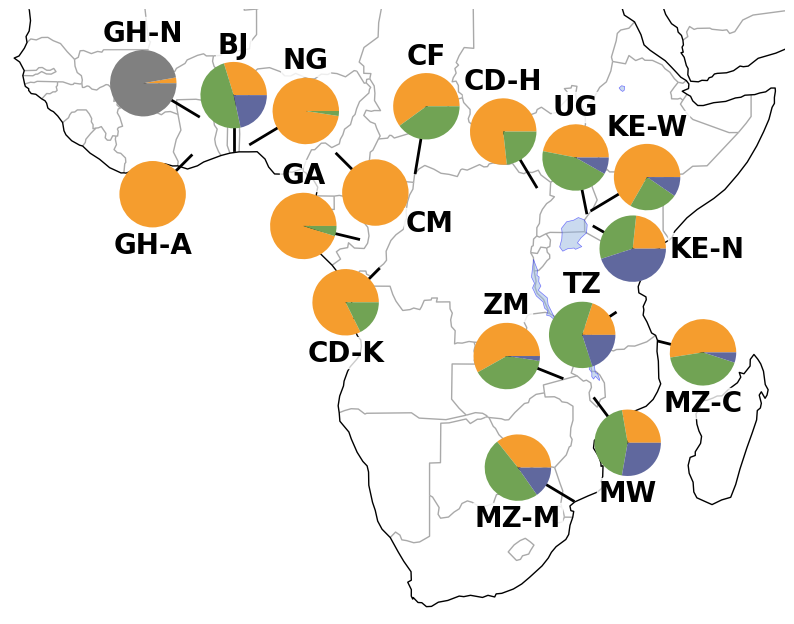

In [16]:
map_karyotypes('3La')

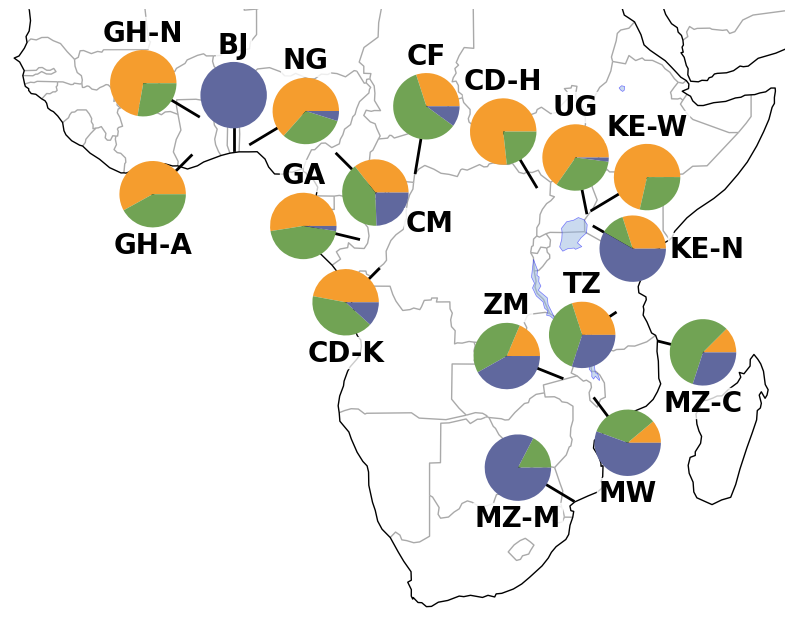

In [57]:
map_karyotypes('3Ra')

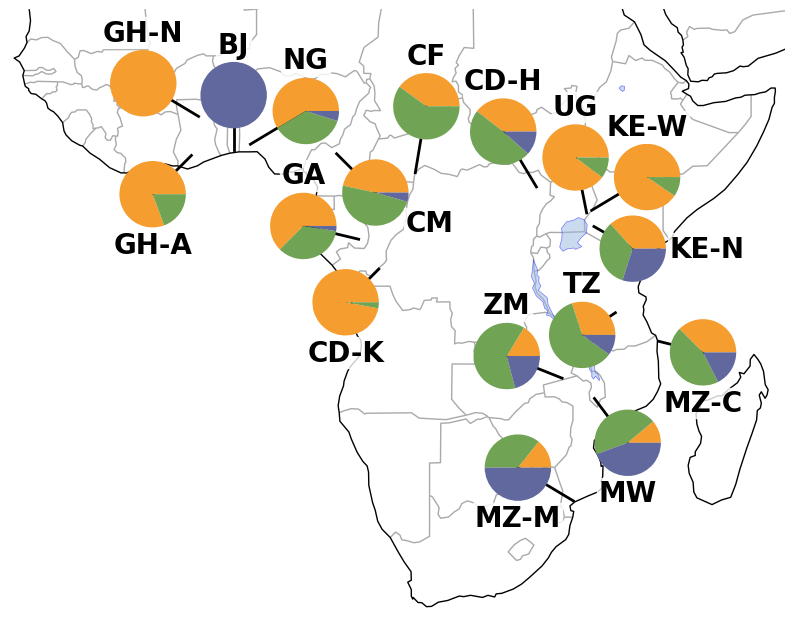

In [58]:
map_karyotypes('3Rb')

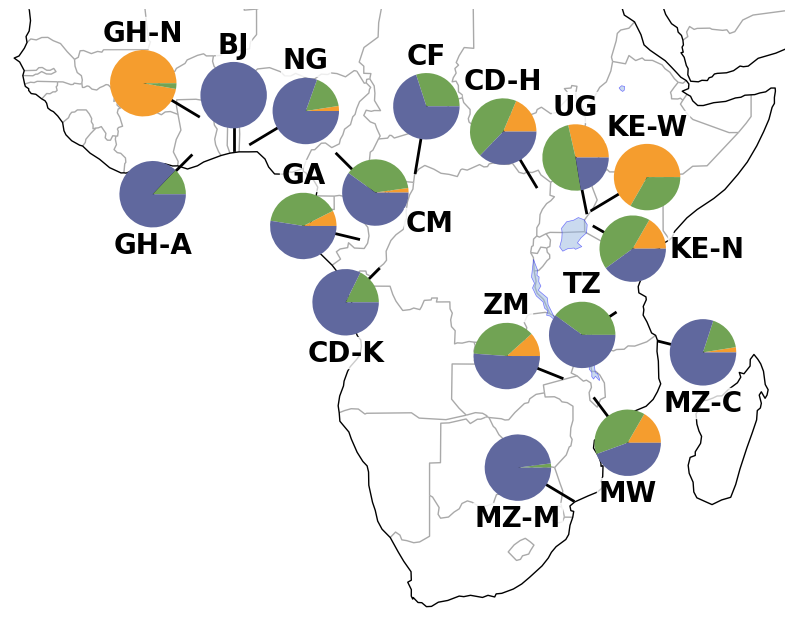

In [59]:
map_karyotypes('2Ra')

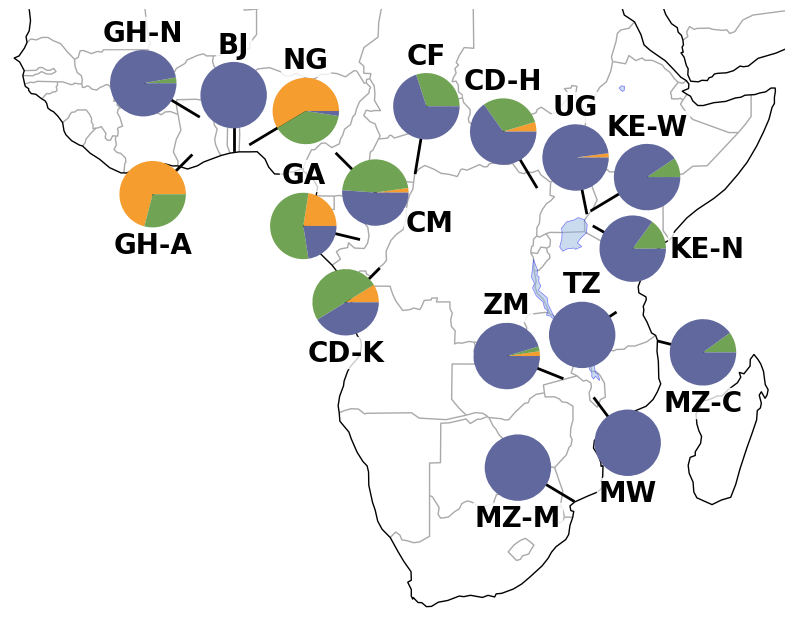

In [60]:
map_karyotypes('2Rh')

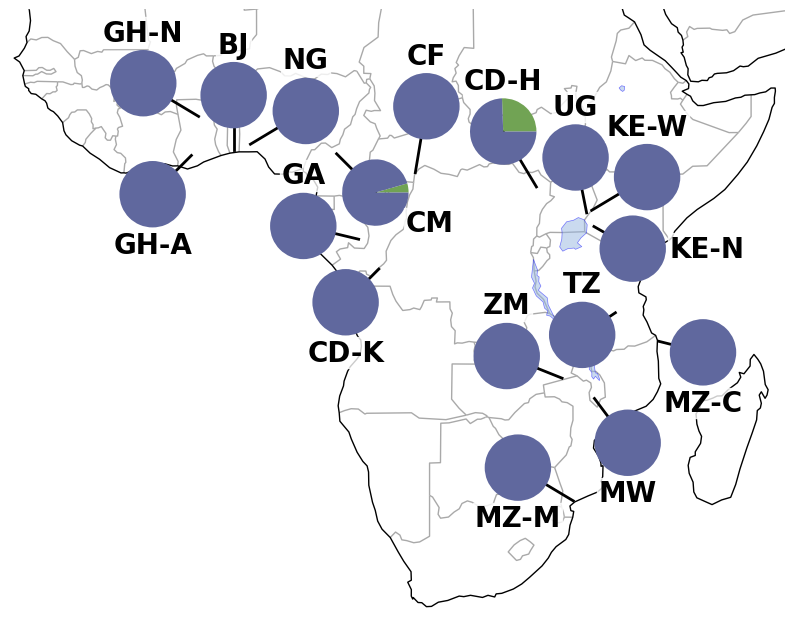

In [61]:
map_karyotypes('2Rt')

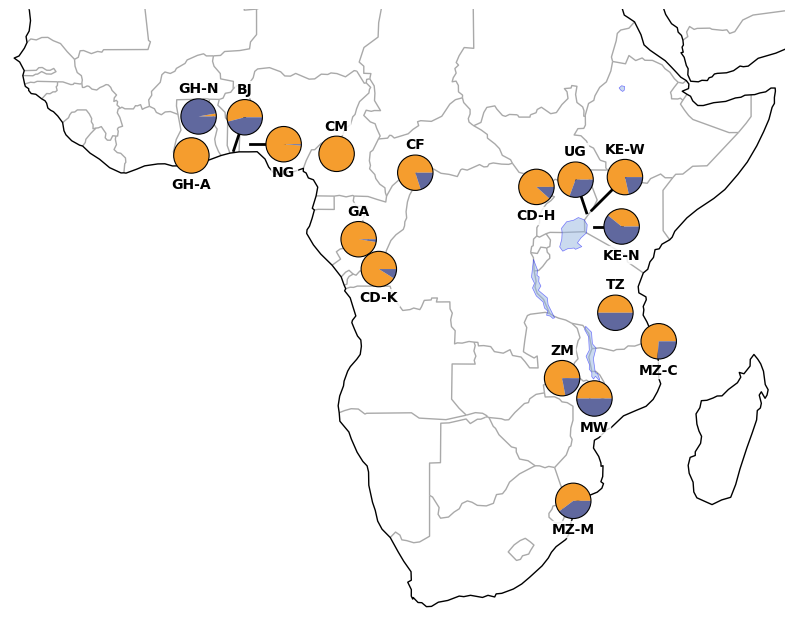

In [175]:
map_frequencies('3La')

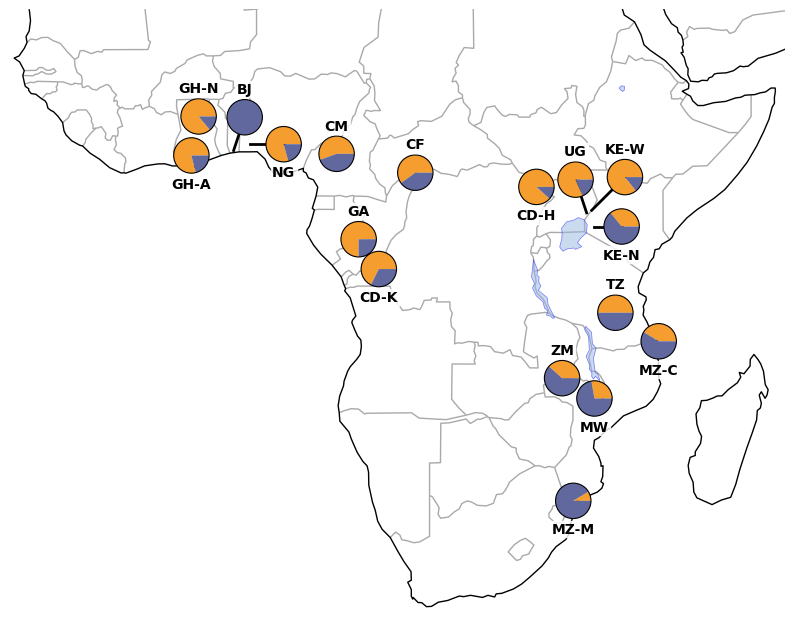

In [176]:
map_frequencies('3Ra')

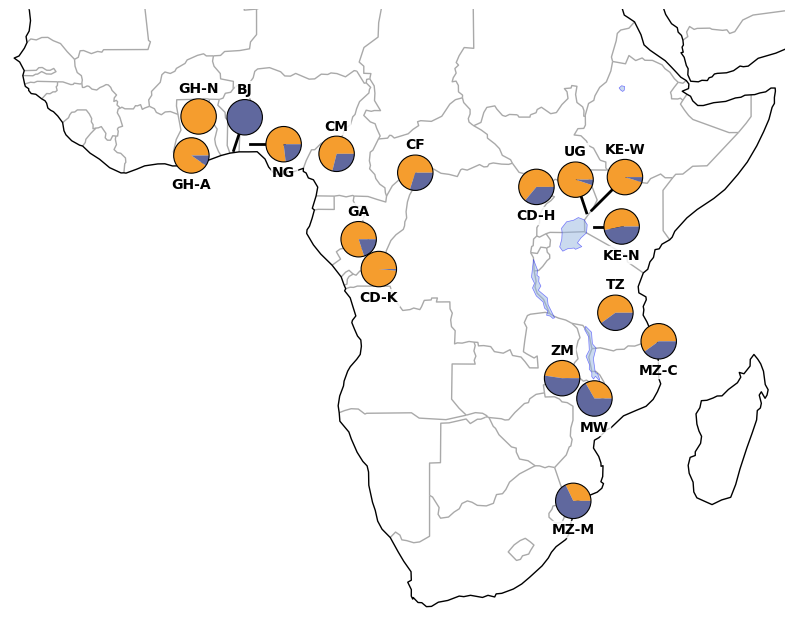

In [177]:
map_frequencies('3Rb')

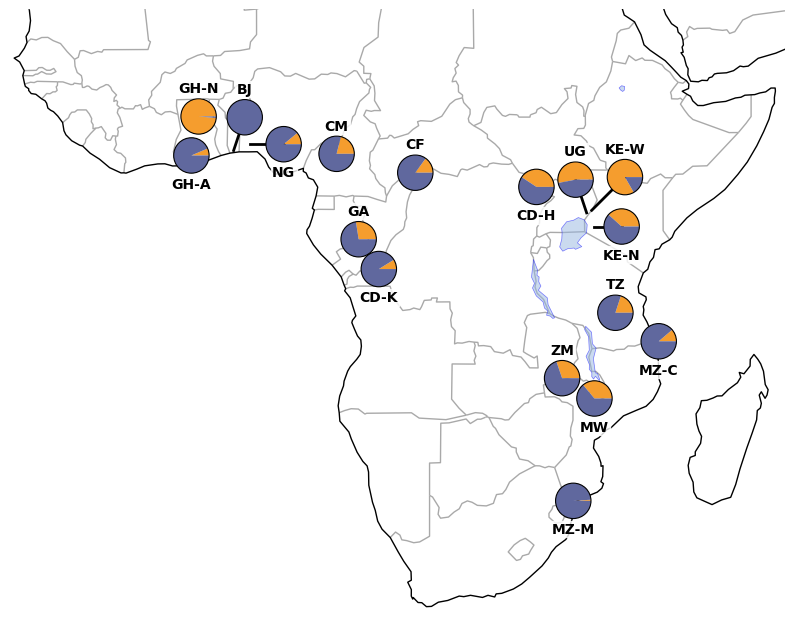

In [178]:
map_frequencies('2Ra')

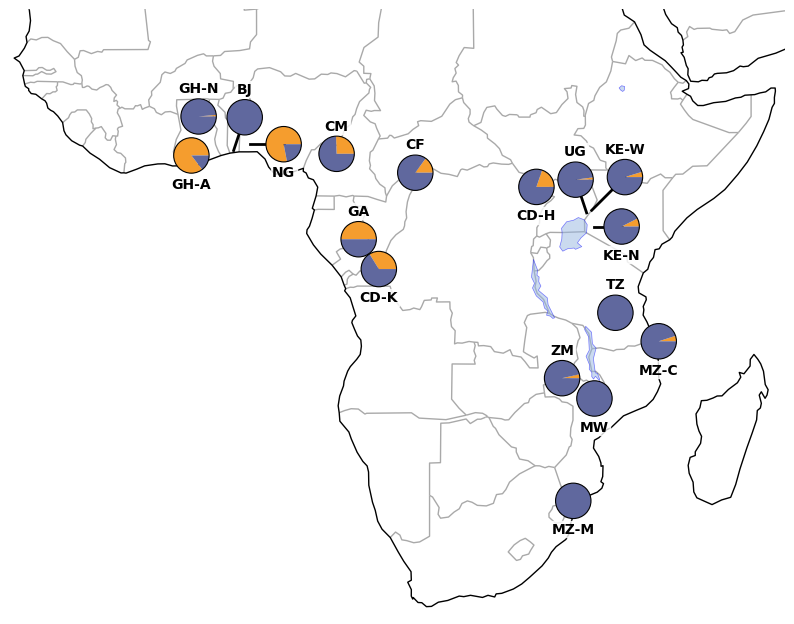

In [179]:
map_frequencies('2Rh')

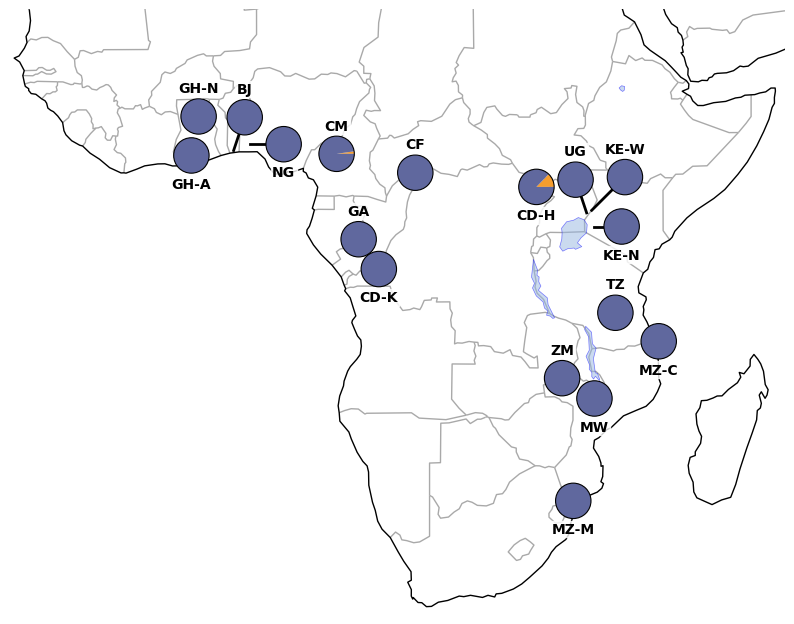

In [180]:
map_frequencies('2Rt')

In [5]:
meta.groupby(['mitochondrial_id', 'geographic_cohort']).size()

mitochondrial_id            geographic_cohort       
funestus-lineageI-clusterA  DRC_Kinshasa                32
                            Gabon_Haut-Ogooue           40
                            Ghana_Ashanti-Region         1
                            Ghana_Northern-Region        2
                            Kenya_Nyanza-Prov            2
                            Malawi_Southern-Region      16
                            Mozambique_Cabo-Delgado     40
                            Mozambique_Maputo           40
                            Tanzania_Morogoro-Region     7
                            Uganda_Eastern-Region        3
                            Zambia_Eastern-Prov         42
funestus-lineageI-clusterB  Benin_Atlantique-Dept       37
                            CAR_Ombella-MPoko           10
                            Cameroon_Adamawa            45
                            DRC_Haut-Uele               40
                            Ghana_Ashanti-Region        29
   

In [6]:
meta.groupby(['geographic_cohort', 'mitochondrial_id']).size()

geographic_cohort         mitochondrial_id          
Benin_Atlantique-Dept     funestus-lineageI-clusterB    37
CAR_Ombella-MPoko         funestus-lineageI-clusterB    10
Cameroon_Adamawa          funestus-lineageI-clusterB    45
DRC_Haut-Uele             funestus-lineageI-clusterB    40
                          funestus-lineageII             3
DRC_Kinshasa              funestus-lineageI-clusterA    32
                          funestus-lineageII             2
Gabon_Haut-Ogooue         funestus-lineageI-clusterA    40
Ghana_Ashanti-Region      funestus-lineageI-clusterA     1
                          funestus-lineageI-clusterB    29
                          funestus-lineageII             1
Ghana_Northern-Region     funestus-lineageI-clusterA     2
                          funestus-lineageI-clusterB    34
Kenya_Nyanza-Prov         funestus-lineageI-clusterA     2
                          funestus-lineageI-clusterB    58
Kenya_Western-Prov        funestus-lineageI-clusterB    21
Mal